In [2]:
import sys
import os
sys.path.append('..')

# Load/Prepare model

In [3]:
import torch
from comic_ocr.models import localization
from comic_ocr.utils import get_path_project_dir
from comic_ocr.utils.pytorch_model import get_total_parameters_count

model_path = get_path_project_dir('data/output/models/localization.bin')
model = localization.load_model()

def save_model(model, model_path):
    torch.save(model, model_path)


print(f'Training [{model_path}] from scratch')

print('- preferred_image_size:', model.preferred_image_size)
print('- get_total_parameters_count', get_total_parameters_count(model))

Training [/Users/wanasit/Workspace/manga-ocr/notebooks/../comic_ocr/utils/../../data/output/models/localization.bin] from scratch
- preferred_image_size: (500, 500)
- get_total_parameters_count 197602


## Load/Prepare Dataset

In [4]:
from comic_ocr.models.localization.localization_dataset import LocalizationDataset
from comic_ocr.utils.ploting import show_images

dataset_generated 2408


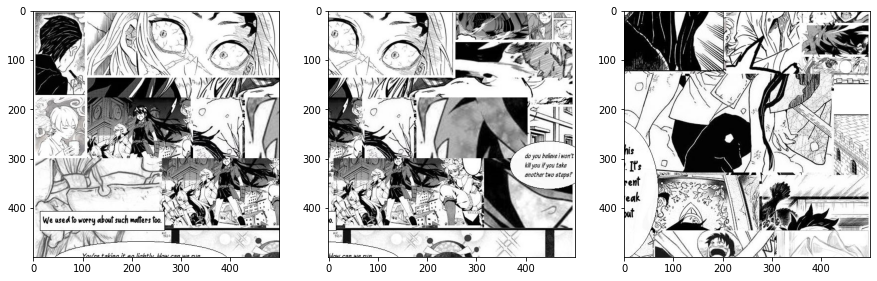

In [5]:
dataset_generated_path = get_path_project_dir('data/output/generate_manga_dataset')
dataset_generated = LocalizationDataset.load_generated_manga_dataset(
    dataset_generated_path, image_size=model.preferred_image_size)

print('dataset_generated', len(dataset_generated))
show_images([
    dataset_generated.get_image(0), 
    dataset_generated.get_image(1), 
    dataset_generated.get_image(-1)
])

dataset_annotated 340


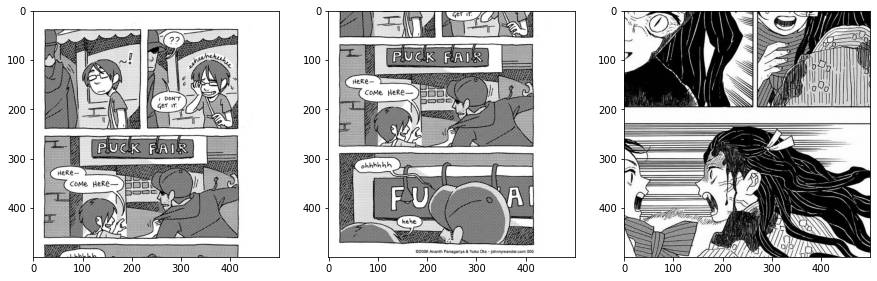

In [6]:
dataset_annotated_path = get_path_project_dir('data/manga_line_annotated')
dataset_annotated = LocalizationDataset.load_line_annotated_manga_dataset(
    dataset_annotated_path, image_size=model.preferred_image_size)

print('dataset_annotated', len(dataset_annotated))

show_images([
    dataset_annotated.get_image(0), 
    dataset_annotated.get_image(1), 
    dataset_annotated.get_image(-5)
])

dataset_example 18


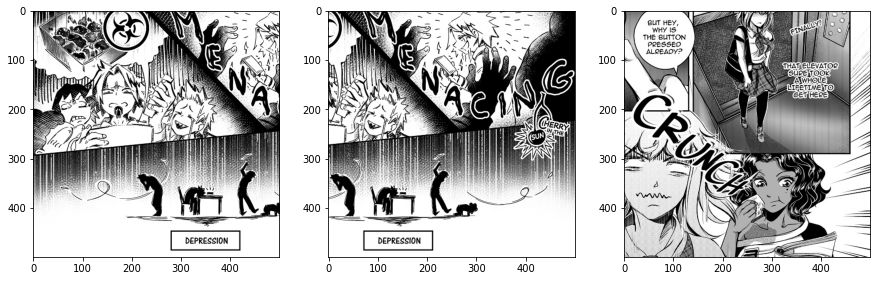

In [7]:
dataset_example_path = get_path_project_dir('example/manga_annotated')
dataset_example = LocalizationDataset.load_line_annotated_manga_dataset(
    dataset_example_path, image_size=model.preferred_image_size)

print('dataset_example', len(dataset_example))


show_images([
    dataset_example.get_image(0), 
    dataset_example.get_image(1), 
    dataset_example.get_image(-5)
])

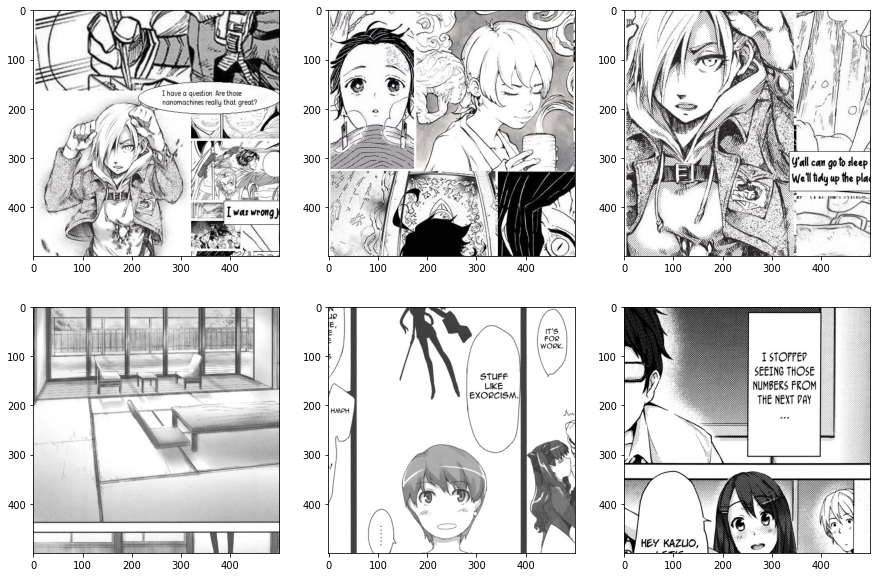

validation_dataset 33
training_dataset 1825


In [8]:
import random
random.seed('abdc')
dataset_annotated = dataset_annotated.shuffle()
dataset_generated = dataset_generated.shuffle()


show_images([
    dataset_generated.get_image(0),
    dataset_generated.get_image(1),
    dataset_generated.get_image(2),
    dataset_annotated.get_image(0), 
    dataset_annotated.get_image(1), 
    dataset_annotated.get_image(2),
])

validation_dataset = LocalizationDataset.merge(
    dataset_example,
    dataset_annotated.subset(to_idx=15)
).shuffle()


training_dataset = LocalizationDataset.merge(
    dataset_generated.subset(from_idx=0, to_idx=1500),
    dataset_annotated.subset(from_idx=15)
).shuffle()

print('validation_dataset', len(validation_dataset))
print('training_dataset', len(training_dataset))

# Training

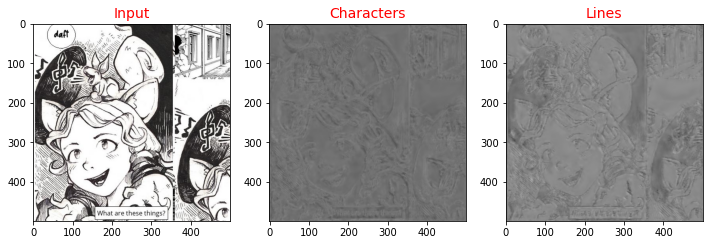

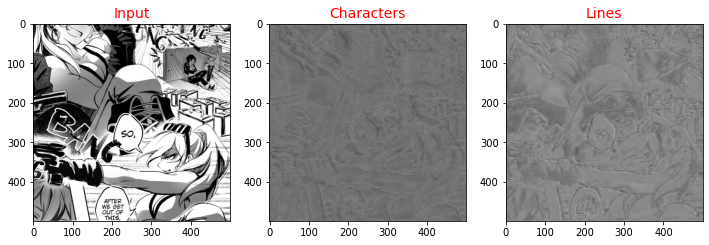

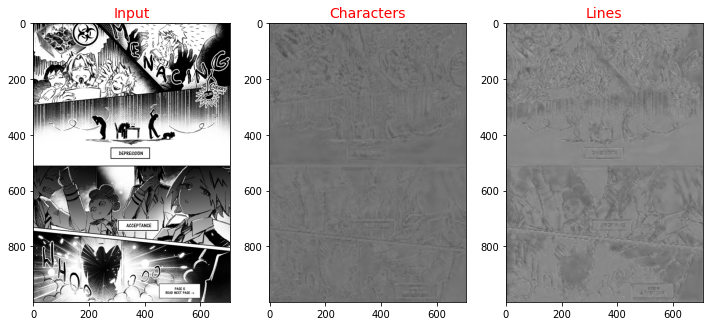

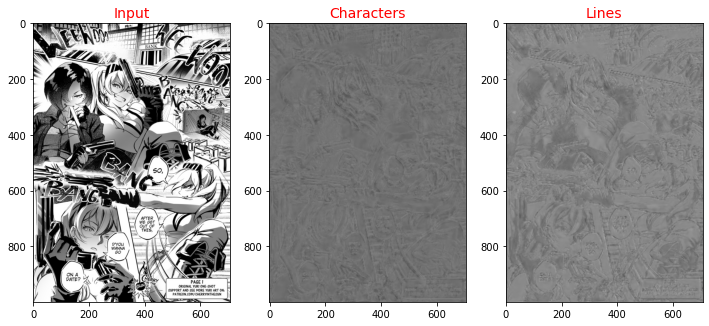

In [30]:
from comic_ocr.utils.ploting import plot_losses, plot_metrics, show_images
from IPython.display import clear_output
from comic_ocr.utils.files import load_image

example_1 = load_image(get_path_project_dir('example/manga_annotated/normal_01.jpg'))
example_2 = load_image(get_path_project_dir('example/manga_annotated/normal_02.jpg'))



def show_example(model, img):
    mask_char, mask_line = model.create_output_marks(img)
    show_images(
        images=[img, mask_char, mask_line], 
        texts=['Input', 'Characters', 'Lines'], 
        figsize=(12, 10), num_col=3
    )

show_example(model, training_dataset.get_image(0))
show_example(model, validation_dataset.get_image(5))
show_example(model, example_1)
show_example(model, example_2)

In [31]:
def save_and_report(i_epoch, train_losses, validation_metrics):
    clear_output()
    plot_metrics(metrics=[
        ('Training Losses', train_losses),
        ('Validation Losses', validation_metrics['validation_loss']),
        ('Line-level Precision', validation_metrics['line_level_precision']),
        ('Line-level Recall', validation_metrics['line_level_recall']),
    ], num_col=2, figsize=(12, 10))
    show_example(model, training_dataset.get_image(0))
    show_example(model, validation_dataset.get_image(5))
    show_example(model, example_1)
    show_example(model, example_2)
    
    torch.save(model, model_path)

<Figure size 864x720 with 0 Axes>

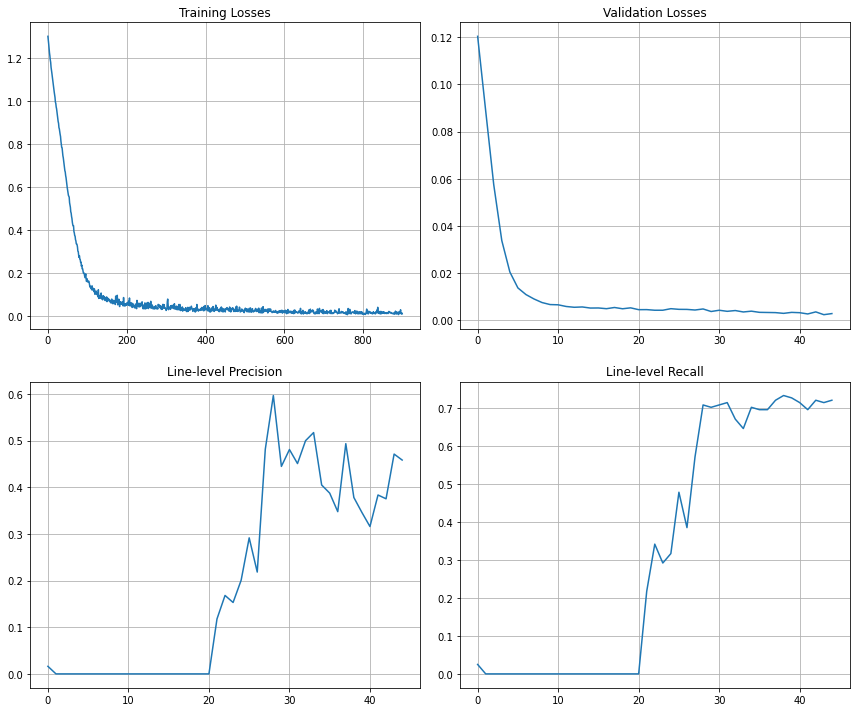

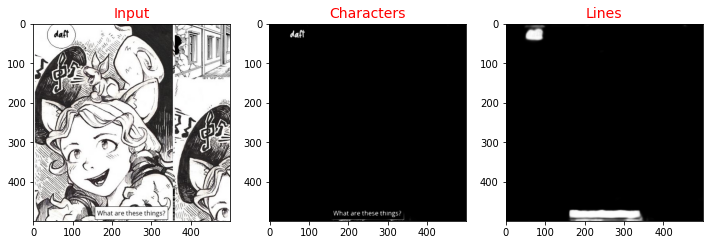

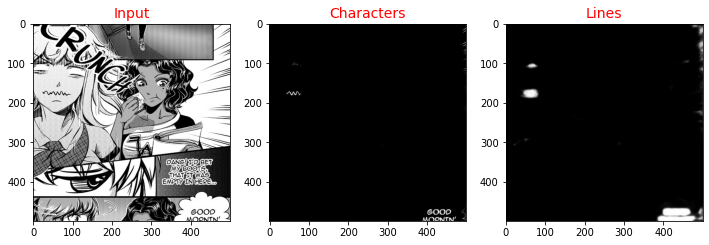

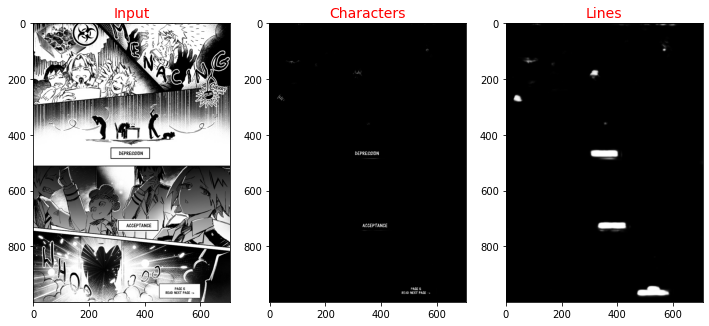

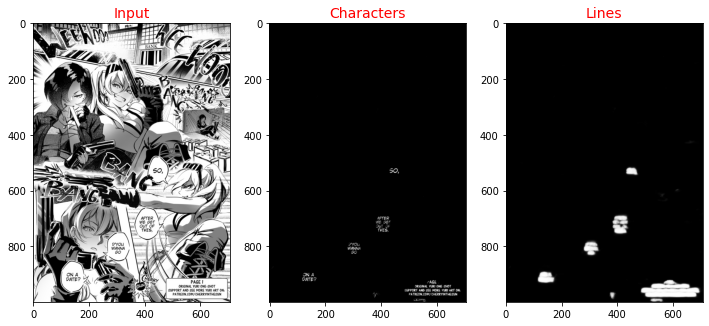

Epoch 4: 100%|███| 1825/1825 [08:55<00:00,  3.41it/s, current_batch_loss=0.0214]


In [32]:
from comic_ocr.models.localization.train import train
_ = train(model,
          train_dataset=training_dataset,
          validate_dataset=validation_dataset,
          update_callback=save_and_report,
          batch_size=10,
          epoch_count=5)

In [15]:
from comic_ocr.models import localization

In [16]:
localization.calculate_high_level_metrics(model, dataset_example)

{'dataset_size': 18,
 'total_line_level_true_positive': 35,
 'total_line_level_false_positive': 27,
 'total_line_level_false_negative': 29,
 'line_level_precision': 0.5645161290322581,
 'line_level_recall': 0.546875,
 'line_level_accuracy': 0.38461538461538464}

In [17]:
localization.calculate_high_level_metrics(model, validation_dataset)

{'dataset_size': 33,
 'total_line_level_true_positive': 112,
 'total_line_level_false_positive': 65,
 'total_line_level_false_negative': 73,
 'line_level_precision': 0.632768361581921,
 'line_level_recall': 0.6054054054054054,
 'line_level_accuracy': 0.448}